# Predicting Heart Disease using Deep Learning

This is my attempt to create a model using deep learning to see if I will get a higher accuracy from the data.

## Step 1. Problem Definition
> The objective of this project is to develop a deep learning model that can effectively predict the presence or absence of heart disease based on various medical and lifestyle factors.


## Step 2. Import the necessary libraries

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
import tensorflow as tf
%matplotlib inline

## Step 3. Load & prepare the data

Most of the cleaning are done on the machine learning part. I will only load the cleaned dataset.

In [2]:
df = pd.read_csv('data/cardio_data_clean.csv')
df.head()

,country,active,age,alco,ap_hi,ap_lo,cholesterol,gender,gluc,occupation,smoke,disease,date_year,date_month,date_day,bmi
0,Indonesia,1,50.391781,0,110,80.0,1,2,1,Architect,0,0,2021,5,3,21.967120
1,Malaysia,1,55.419178,0,140,90.0,3,1,1,Accountant,0,1,2021,8,5,34.927679
2,Indonesia,0,51.663014,0,130,70.0,3,1,1,Chef,0,1,2022,11,13,23.507805
3,Singapore,1,48.282192,0,150,100.0,1,2,1,Lawyer,0,1,2018,10,31,28.710479
4,Singapore,0,47.873973,0,100,60.0,1,1,1,Architect,0,0,2020,9,25,23.011177


I'm just going to move the target variable at the end of the dataframe for presentation purposes.

In [3]:
# Move the target column to the last column using list comprehension
target_column = 'disease'
df = df[[col for col in df.columns if col != target_column] + [target_column]]
df.head()

,country,active,age,alco,ap_hi,ap_lo,cholesterol,gender,gluc,occupation,smoke,date_year,date_month,date_day,bmi,disease
0,Indonesia,1,50.391781,0,110,80.0,1,2,1,Architect,0,2021,5,3,21.967120,0
1,Malaysia,1,55.419178,0,140,90.0,3,1,1,Accountant,0,2021,8,5,34.927679,1
2,Indonesia,0,51.663014,0,130,70.0,3,1,1,Chef,0,2022,11,13,23.507805,1
3,Singapore,1,48.282192,0,150,100.0,1,2,1,Lawyer,0,2018,10,31,28.710479,1
4,Singapore,0,47.873973,0,100,60.0,1,1,1,Architect,0,2020,9,25,23.011177,0


## Step 4. Data Preprocessing

We have to preprocess the data, this includes the following:

1. Creating X & y
2. Cyclic encode the dates
3. Encoding Categorical features
4. Split the data
5. Feature scaling

### Create X & y

Cyclic encoding of the dates is important to show the model that these values are recurring. This will be performed only on day and month columns only.

In [4]:
X = df.drop(['disease'], axis=1)
y = df['disease']

In [5]:
X.head()

,country,active,age,alco,ap_hi,ap_lo,cholesterol,gender,gluc,occupation,smoke,date_year,date_month,date_day,bmi
0,Indonesia,1,50.391781,0,110,80.0,1,2,1,Architect,0,2021,5,3,21.967120
1,Malaysia,1,55.419178,0,140,90.0,3,1,1,Accountant,0,2021,8,5,34.927679
2,Indonesia,0,51.663014,0,130,70.0,3,1,1,Chef,0,2022,11,13,23.507805
3,Singapore,1,48.282192,0,150,100.0,1,2,1,Lawyer,0,2018,10,31,28.710479
4,Singapore,0,47.873973,0,100,60.0,1,1,1,Architect,0,2020,9,25,23.011177


In [7]:
y.head()

0    0
1    1
2    1
3    1
4    0
Name: disease, dtype: int64

### Cyclic encoding

Cyclic encoding is done to encode date values particularly month and day to tell the model that these values are recurring.

Create a function that will encode dates cyclically.

In [8]:
def cyclic_encode(df, column_list, year_column_list):
    """
    This function analyze a given dataset with the given month/day column list and year column list. 
    It will determine first if year is a leap year then proceed to encode the proper count of days for February.
    """
    # Import library needed
    import calendar
    
    # Iterate through the list to get the column name
    for col in column_list:
        # Create an if function to check if the column name is month
        if df[col].max() <= 12:
            # Perform cyclic encoding for month
            df[col+'_sin'] = np.sin(2 * np.pi * df[col] / 12)
            df[col+'_cos'] = np.cos(2 * np.pi * df[col] / 12)

        # This will now perform encoding for day column
        elif df[col].max() > 12:
            for year_col in year_column_list:  # Iterate through year columns
                for i, row in enumerate(df[year_col]):
                    # Check if it's a leap year
                    is_leap_year = calendar.isleap(row)
                    
                    # Adjust divisor based on the number of days in the month
                    if col in [1, 3, 5, 7, 8, 10, 12]:
                        divisor = 31
                    elif col == 2:
                        divisor = 29 if is_leap_year else 28
                    else:
                        divisor = 30
                    # Perform cyclic encoding for day
                    df.at[i, col + '_sin'] = np.sin(2 * np.pi * df.at[i, col] / divisor)
                    df.at[i, col + '_cos'] = np.cos(2 * np.pi * df.at[i, col] / divisor)

        # Drop the original dates column
        df.drop(col, axis=1, inplace=True)
    
    return df

Encode the date_month & date_day columns

In [9]:
# Create a list for the day & months columns
date_col = ['date_month', 'date_day']

# Make a list also for year
year_col = ['date_year']

# Perform cyclic encoding
cyclic_encode(df=X,
              column_list=date_col,
              year_column_list=year_col)

,country,active,age,alco,ap_hi,ap_lo,cholesterol,gender,gluc,occupation,smoke,date_year,bmi,date_month_sin,date_month_cos,date_day_sin,date_day_cos
0,Indonesia,1,50.391781,0,110,80.0,1,2,1,Architect,0,2021,21.967120,0.500000,-8.660254e-01,5.877853e-01,0.809017
1,Malaysia,1,55.419178,0,140,90.0,3,1,1,Accountant,0,2021,34.927679,-0.866025,-5.000000e-01,8.660254e-01,0.500000
2,Indonesia,0,51.663014,0,130,70.0,3,1,1,Chef,0,2022,23.507805,-0.500000,8.660254e-01,4.067366e-01,-0.913545
3,Singapore,1,48.282192,0,150,100.0,1,2,1,Lawyer,0,2018,28.710479,-0.866025,5.000000e-01,2.079117e-01,0.978148
4,Singapore,0,47.873973,0,100,60.0,1,1,1,Architect,0,2020,23.011177,-1.000000,-1.836970e-16,-8.660254e-01,0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,Singapore,1,52.712329,0,120,80.0,1,2,1,Doctor,1,2018,26.927438,0.866025,-5.000000e-01,5.877853e-01,0.809017
69996,Malaysia,1,61.920548,0,140,90.0,2,1,2,Accountant,0,2022,50.472681,0.500000,8.660254e-01,5.877853e-01,-0.809017
69997,Malaysia,0,52.235616,1,180,90.0,3,2,1,Accountant,0,2022,31.353579,-0.866025,-5.000000e-01,-8.660254e-01,0.500000
69998,Singapore,0,61.454795,0,135,80.0,1,1,2,Accountant,0,2020,27.099251,-0.500000,-8.660254e-01,4.067366e-01,-0.913545


### Encoding categorical features

Using pandas `get_dummies` I will one hot encode the categorical features, but if the categorical feature is an object/str I don't like a prefix, but if the categorical feature is integer, I will retain the prefix.

In [46]:
# Filter first the numeric category with unique values less than 5
X_cat_num = [col for col in X.columns if X[col].dtype == 'int64' and X[col].nunique() < 5]
X_cat_num

['active', 'alco', 'cholesterol', 'gender', 'gluc', 'smoke']

In [48]:
# Filter the object
X_cat_str = [col for col in X.columns if X[col].dtype == 'O']
X_cat_str

['country', 'occupation']

In [51]:
# Perform pandas get_dummies for numeric category
X_one_hot = pd.get_dummies(X,
                           columns=X_cat_num,
                           prefix_sep=' ', # use space to separate the prefix to the value
                           dtype=int)
X_one_hot.head().T

,0,1,2,3,4
country,Indonesia,Malaysia,Indonesia,Singapore,Singapore
age,50.391781,55.419178,51.663014,48.282192,47.873973
ap_hi,110,140,130,150,100
ap_lo,80.0,90.0,70.0,100.0,60.0
occupation,Architect,Accountant,Chef,Lawyer,Architect
date_year,2021,2021,2022,2018,2020
bmi,21.96712,34.927679,23.507805,28.710479,23.011177
date_month_sin,0.5,-0.866025,-0.5,-0.866025,-1.0
date_month_cos,-0.866025,-0.5,0.866025,0.5,-0.0
date_day_sin,0.587785,0.866025,0.406737,0.207912,-0.866025


In [52]:
# Perform pandas get_dummies for object/str category
X_one_hot = pd.get_dummies(X_one_hot, # now perform on the one hot encoded dataframe
                           columns=X_cat_str,
                           prefix='',
                           prefix_sep='', 
                           dtype=int)
X_one_hot.head().T

,0,1,2,3,4
age,50.391781,55.419178,51.663014,48.282192,4.787397e+01
ap_hi,110.000000,140.000000,130.000000,150.000000,1.000000e+02
ap_lo,80.000000,90.000000,70.000000,100.000000,6.000000e+01
date_year,2021.000000,2021.000000,2022.000000,2018.000000,2.020000e+03
bmi,21.967120,34.927679,23.507805,28.710479,2.301118e+01
date_month_sin,0.500000,-0.866025,-0.500000,-0.866025,-1.000000e+00
date_month_cos,-0.866025,-0.500000,0.866025,0.500000,-1.836970e-16
date_day_sin,0.587785,0.866025,0.406737,0.207912,-8.660254e-01
date_day_cos,0.809017,0.500000,-0.913545,0.978148,5.000000e-01
active 0,0.000000,0.000000,1.000000,0.000000,1.000000e+00


### Split the data set into training, validation and test set

We will be using validation set for validation data in neural network

In [53]:
# Import train_test_split
from sklearn.model_selection import train_test_split as tts 

# Split to train set and temporary set
X_train, X_temp, y_train, y_temp = tts(X_one_hot, y, test_size=0.30, random_state=42)

# Split temp to validation and test set
X_val, X_test, y_val, y_test = tts(X_temp, y_temp, test_size=0.50, random_state=42)

# Check the shapes
X_train.shape, X_val.shape, X_test.shape

((49000, 36), (10500, 36), (10500, 36))

### Feature Scaling

In [54]:
# Get all the remaining numeric features to encode
scale_col = [col for col in X_train.columns if X_train[col].max() > 4]
scale_col

['age', 'ap_hi', 'ap_lo', 'date_year', 'bmi']

In [56]:
# Import library
from sklearn.preprocessing import StandardScaler

# Instantiate the StandardScaler
sc = StandardScaler()

# Always use fit_transform for the train set
X_train[scale_col] = sc.fit_transform(X_train[scale_col])

# Use transform only for other set like validation and test
X_val[scale_col] = sc.transform(X_val[scale_col])
X_test[scale_col] = sc.transform(X_test[scale_col])

X_train.head(3).T

,68681,19961,11040
age,0.388149,1.309275,1.347368
ap_hi,-0.399588,-0.399588,-0.399588
ap_lo,0.746770,-0.181509,0.746770
date_year,1.411251,-0.711734,0.703589
bmi,-0.477011,-0.802001,-0.327070
date_month_sin,0.500000,-0.500000,0.866025
date_month_cos,-0.866025,0.866025,0.500000
date_day_sin,0.743145,0.587785,0.587785
date_day_cos,-0.669131,-0.809017,0.809017
active 0,0.000000,1.000000,0.000000


## Step 5. Create a neural network architecture

1. Basic model first.
2. Tune the model by:
    * Increasing the layers.
    * Finding the appropriate learning rate.
    * Changing activations, optimizers etc.

### Model 1

1. 2 Hidden layers with 4 neurons each, and ouput layer of 1 for binary problem.
2. Compile using loss of `tf.keras.losses.BinaryCrossentropy()`, optimizer of `tf.keras.optimizers.SGD()` and metrics of 'accuracy'.
3. Fit the model using validation set as validation in 20 epochs and 16 batch size.

In [58]:
# Set the random seed
tf.random.set_seed(42)

# Create a model_1 for heart disease
model_1 = tf.keras.Sequential([
    tf.keras.layers.Dense(4),
    tf.keras.layers.Dense(4),
    tf.keras.layers.Dense(1)
])

# Compile
model_1.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.SGD(),
                metrics=['accuracy'])

# Fit the model and save history
history_1 = model_1.fit(X_train,
                        y_train,
                        epochs=20,
                        batch_size=16,
                        validation_data=(X_val, y_val))

Epoch 1/20
3063/3063 [==============================] - 7s 2ms/step - loss: 7.1505 - accuracy: 0.5141 - val_loss: 7.6598 - val_accuracy: 0.4977
Epoch 2/20
3063/3063 [==============================] - 6s 2ms/step - loss: 7.6558 - accuracy: 0.4977 - val_loss: 7.6613 - val_accuracy: 0.4976
Epoch 3/20
3063/3063 [==============================] - 6s 2ms/step - loss: 7.6540 - accuracy: 0.4980 - val_loss: 7.6628 - val_accuracy: 0.4974
Epoch 4/20
3063/3063 [==============================] - 7s 2ms/step - loss: 7.6494 - accuracy: 0.4983 - val_loss: 7.6568 - val_accuracy: 0.4979
Epoch 5/20
3063/3063 [==============================] - 6s 2ms/step - loss: 7.6465 - accuracy: 0.4986 - val_loss: 7.6466 - val_accuracy: 0.4985
Epoch 6/20
3063/3063 [==============================] - 6s 2ms/step - loss: 7.6464 - accuracy: 0.4985 - val_loss: 7.6465 - val_accuracy: 0.4986
Epoch 7/20
3063/3063 [==============================] - 6s 2ms/step - loss: 7.6443 - accuracy: 0.4987 - val_loss: 7.6480 - val_accuracy:

Let's visualize what happened during the training in model 1.

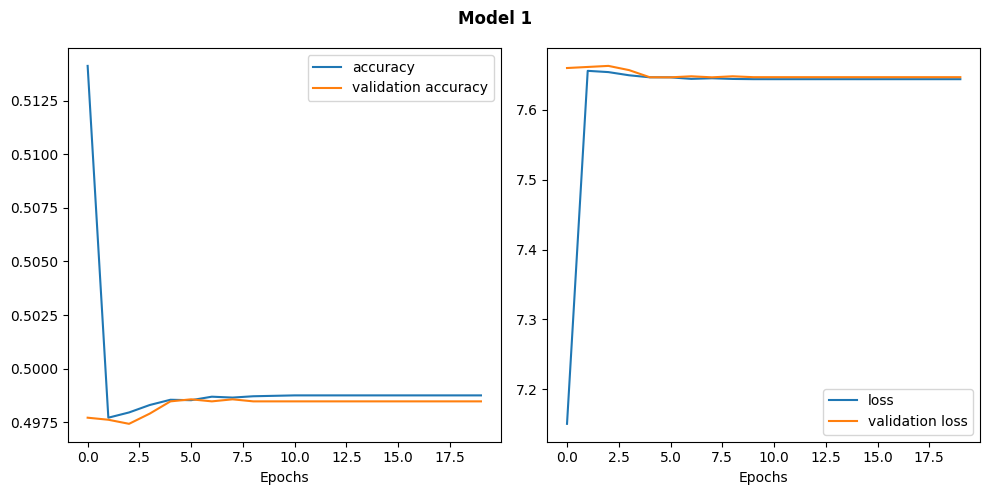

In [84]:
# Make history a DataFrame
model_1_hist = pd.DataFrame(history_1.history)

# Plot using subplots
fig, ax = plt.subplots(figsize=(10,5),
                       nrows=1,
                       ncols=2)

ax[0].plot(model_1_hist[['accuracy', 'val_accuracy']], label=['accuracy', 'validation accuracy'])
ax[0].set_xlabel('Epochs')
ax[0].legend()

ax[1].plot(model_1_hist[['loss', 'val_loss']], label=['loss', 'validation loss'])
ax[1].set_xlabel('Epochs')
ax[1].legend()

fig.suptitle('Model 1', fontweight='bold')

plt.tight_layout()
plt.show()

Welp, that's 50-50 more like guessing. Let's see if we can improve our model.

### Model 2

1. 3 Hidden layers with 10, 10, 5 neurons respectively with relu activation, and ouput layer of 1 with sigmoid activation for binary problem.
2. Compile using loss of `tf.keras.losses.BinaryCrossentropy()`, optimizer of `tf.keras.optimizers.Adam()` using default learning rate and metrics of 'accuracy'.
3. Fit the model using validation set as validation in 40 epochs and 32 batch size.

In [80]:
# Set random seed
tf.random.set_seed(42)

# Create the model
model_2 = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(5, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model_2.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

# Fit the model and save history
history_2 = model_2.fit(X_train,
                        y_train,
                        epochs=40,
                        batch_size=32,
                        validation_data=(X_val, y_val))

Epoch 1/40
1532/1532 [==============================] - 5s 2ms/step - loss: 0.5732 - accuracy: 0.7084 - val_loss: 0.5515 - val_accuracy: 0.7291
Epoch 2/40
1532/1532 [==============================] - 4s 2ms/step - loss: 0.5498 - accuracy: 0.7289 - val_loss: 0.5455 - val_accuracy: 0.7325
Epoch 3/40
1532/1532 [==============================] - 3s 2ms/step - loss: 0.5471 - accuracy: 0.7305 - val_loss: 0.5453 - val_accuracy: 0.7317
Epoch 4/40
1532/1532 [==============================] - 3s 2ms/step - loss: 0.5454 - accuracy: 0.7316 - val_loss: 0.5441 - val_accuracy: 0.7322
Epoch 5/40
1532/1532 [==============================] - 3s 2ms/step - loss: 0.5445 - accuracy: 0.7325 - val_loss: 0.5421 - val_accuracy: 0.7342
Epoch 6/40
1532/1532 [==============================] - 3s 2ms/step - loss: 0.5434 - accuracy: 0.7331 - val_loss: 0.5410 - val_accuracy: 0.7333
Epoch 7/40
1532/1532 [==============================] - 3s 2ms/step - loss: 0.5429 - accuracy: 0.7331 - val_loss: 0.5419 - val_accuracy:

Let's visualize what happened during the training in model 2.

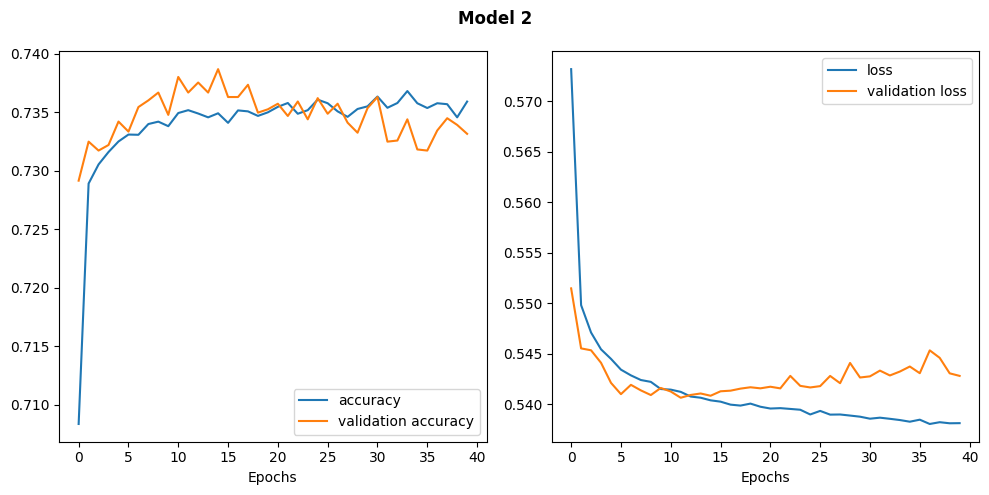

In [81]:
# Make history a DataFrame
model_2_hist = pd.DataFrame(history_2.history)

# Plot using subplots
fig, ax = plt.subplots(figsize=(10,5),
                       nrows=1,
                       ncols=2)

ax[0].plot(model_2_hist[['accuracy', 'val_accuracy']], label=['accuracy', 'validation accuracy'])
ax[0].set_xlabel('Epochs')
ax[0].legend()

ax[1].plot(model_2_hist[['loss', 'val_loss']], label=['loss', 'validation loss'])
ax[1].set_xlabel('Epochs')
ax[1].legend()

fig.suptitle('Model 2', fontweight='bold')

plt.tight_layout()
plt.show()

### Model 3

1. 3 Hidden layers with 100, 100, 50 neurons respectively with relu and leakyrelu activation, and ouput layer of 1 with sigmoid activation for binary problem.
2. Compile using loss of `tf.keras.losses.BinaryCrossentropy()`, optimizer of `tf.keras.optimizers.Adam()` using default learning rate and metrics of 'accuracy'.
3. Fit the model using validation set as validation in 40 epochs and 32 batch size.

In [87]:
# Set random seed
tf.random.set_seed(42)

# Create model
model_3 = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation=tf.keras.layers.LeakyReLU(alpha=0.01)),
    tf.keras.layers.Dense(100, activation=tf.keras.activations.relu),
    tf.keras.layers.Dense(50, activation=tf.keras.layers.LeakyReLU(alpha=0.02)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model_3.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

# Fit the model and save history
history_3 = model_3.fit(X_train,
                        y_train,
                        epochs=40,
                        batch_size=32,
                        validation_data=(X_val, y_val))

Epoch 1/40
1532/1532 [==============================] - 6s 3ms/step - loss: 0.5551 - accuracy: 0.7238 - val_loss: 0.5458 - val_accuracy: 0.7335
Epoch 2/40
1532/1532 [==============================] - 4s 3ms/step - loss: 0.5458 - accuracy: 0.7305 - val_loss: 0.5432 - val_accuracy: 0.7338
Epoch 3/40
1532/1532 [==============================] - 4s 3ms/step - loss: 0.5432 - accuracy: 0.7330 - val_loss: 0.5439 - val_accuracy: 0.7343
Epoch 4/40
1532/1532 [==============================] - 4s 3ms/step - loss: 0.5405 - accuracy: 0.7348 - val_loss: 0.5462 - val_accuracy: 0.7369
Epoch 5/40
1532/1532 [==============================] - 4s 3ms/step - loss: 0.5387 - accuracy: 0.7363 - val_loss: 0.5428 - val_accuracy: 0.7335
Epoch 6/40
1532/1532 [==============================] - 5s 3ms/step - loss: 0.5361 - accuracy: 0.7377 - val_loss: 0.5437 - val_accuracy: 0.7350
Epoch 7/40
1532/1532 [==============================] - 4s 3ms/step - loss: 0.5334 - accuracy: 0.7396 - val_loss: 0.5429 - val_accuracy:

Let's visualize what happened during the training in model 3.

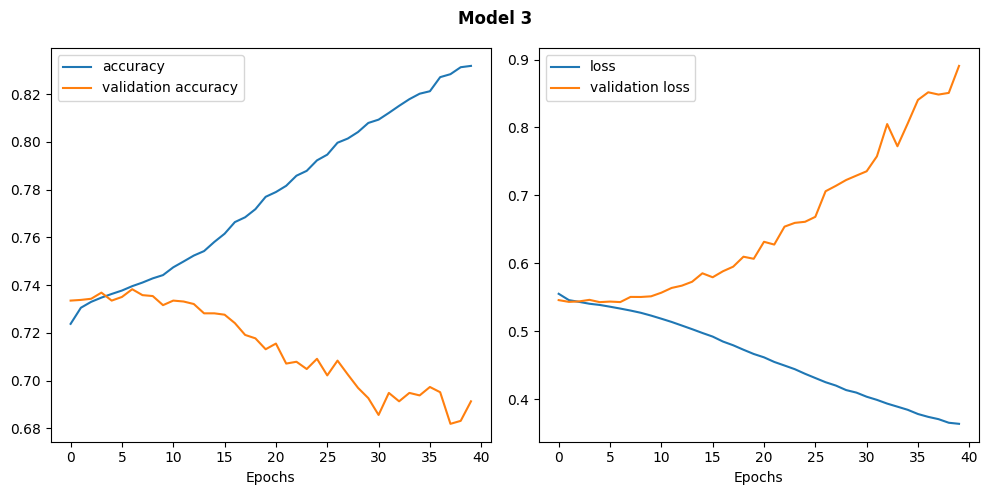

In [88]:
# Make history a DataFrame
model_3_hist = pd.DataFrame(history_3.history)

# Plot using subplots
fig, ax = plt.subplots(figsize=(10,5),
                       nrows=1,
                       ncols=2)

ax[0].plot(model_3_hist[['accuracy', 'val_accuracy']], label=['accuracy', 'validation accuracy'])
ax[0].set_xlabel('Epochs')
ax[0].legend()

ax[1].plot(model_3_hist[['loss', 'val_loss']], label=['loss', 'validation loss'])
ax[1].set_xlabel('Epochs')
ax[1].legend()

fig.suptitle('Model 3', fontweight='bold')

plt.tight_layout()
plt.show()

### Observations

* Model 1 as expected to baseline models has the lowest accuracy at 50%, at that stage the model is more likely guessing.
* Model 3 has signs of overfitting, as the accuracy from training increases, the accuracy from the validation decreases. This means that although the model is good in finding patterns on the training set, it failed to generalize on the validation set.
* Model 2 is just right on although still low in accuracy, we will try to improve it more.

### Tuning Model 2

Although the architecture is very much done, we can still try few things to improve the model.

We will try to find the best learning rate using `LearningRateScheduler` from tensorflow.

In [90]:
model_2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_11 (Dense)            (None, 10)                370       
                                                                 
 dense_12 (Dense)            (None, 10)                110       
                                                                 
 dense_13 (Dense)            (None, 5)                 55        
                                                                 
 dense_14 (Dense)            (None, 1)                 6         
                                                                 
Total params: 541 (2.11 KB)
Trainable params: 541 (2.11 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [91]:
# Let's recreate the model_2

# Set random seed
tf.random.set_seed(42)

# Create model
model_2 = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(5, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model_2.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

# Create a learning rate callback
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch/20))

# Fit the model using lr_scheduler as callbak
history_2 = model_2.fit(X_train,
                        y_train,
                        epochs=40,
                        batch_size=32,
                        validation_data=(X_val, y_val),
                        callbacks=[lr_scheduler])

Epoch 1/40
1532/1532 [==============================] - 5s 2ms/step - loss: 0.6467 - accuracy: 0.6523 - val_loss: 0.5949 - val_accuracy: 0.6987 - lr: 1.0000e-04
Epoch 2/40
1532/1532 [==============================] - 3s 2ms/step - loss: 0.5781 - accuracy: 0.7080 - val_loss: 0.5660 - val_accuracy: 0.7166 - lr: 1.1220e-04
Epoch 3/40
1532/1532 [==============================] - 3s 2ms/step - loss: 0.5640 - accuracy: 0.7194 - val_loss: 0.5583 - val_accuracy: 0.7228 - lr: 1.2589e-04
Epoch 4/40
1532/1532 [==============================] - 3s 2ms/step - loss: 0.5586 - accuracy: 0.7232 - val_loss: 0.5548 - val_accuracy: 0.7270 - lr: 1.4125e-04
Epoch 5/40
1532/1532 [==============================] - 3s 2ms/step - loss: 0.5558 - accuracy: 0.7255 - val_loss: 0.5524 - val_accuracy: 0.7275 - lr: 1.5849e-04
Epoch 6/40
1532/1532 [==============================] - 3s 2ms/step - loss: 0.5538 - accuracy: 0.7267 - val_loss: 0.5504 - val_accuracy: 0.7290 - lr: 1.7783e-04
Epoch 7/40
1532/1532 [============

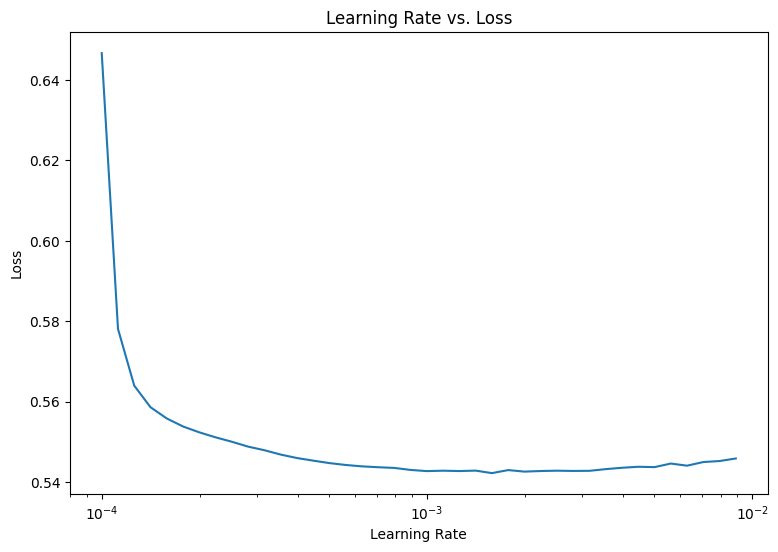

In [94]:
# Plot the learning rate vs loss
lrs = 1e-4 * (10 ** (tf.range(40)/20)) # use 40 as hardcoded value of the epoch

plt.figure(figsize=(9,6))
plt.semilogx(lrs, history_2.history['loss'])

plt.xlabel('Learning Rate')
plt.ylabel('Loss')
plt.title('Learning Rate vs. Loss');

Base on the plot, looks like the lowest point of the curve happend around 10e-3. We can use that to our model as our learning rate.

In [95]:
# Set random seed
tf.random.set_seed(42)

# Create the model
model_2 = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(5, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model_2.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), # use the learning rate found on the learning reate scheduler
                metrics=['accuracy'])

# Fit the model and save history
history_2 = model_2.fit(X_train,
                        y_train,
                        epochs=40,
                        batch_size=32,
                        validation_data=(X_val, y_val))

Epoch 1/40
1532/1532 [==============================] - 7s 4ms/step - loss: 0.5567 - accuracy: 0.7251 - val_loss: 0.5480 - val_accuracy: 0.7300
Epoch 2/40
1532/1532 [==============================] - 3s 2ms/step - loss: 0.5491 - accuracy: 0.7280 - val_loss: 0.5430 - val_accuracy: 0.7322
Epoch 3/40
1532/1532 [==============================] - 3s 2ms/step - loss: 0.5479 - accuracy: 0.7300 - val_loss: 0.5425 - val_accuracy: 0.7317
Epoch 4/40
1532/1532 [==============================] - 3s 2ms/step - loss: 0.5471 - accuracy: 0.7299 - val_loss: 0.5435 - val_accuracy: 0.7325
Epoch 5/40
1532/1532 [==============================] - 3s 2ms/step - loss: 0.5474 - accuracy: 0.7298 - val_loss: 0.5423 - val_accuracy: 0.7316
Epoch 6/40
1532/1532 [==============================] - 3s 2ms/step - loss: 0.5464 - accuracy: 0.7304 - val_loss: 0.5429 - val_accuracy: 0.7327
Epoch 7/40
1532/1532 [==============================] - 3s 2ms/step - loss: 0.5465 - accuracy: 0.7308 - val_loss: 0.5432 - val_accuracy:

Let's evaluate the model on test set

In [97]:
model_2.evaluate(X_test, y_test)

329/329 [==============================] - 1s 2ms/step - loss: 0.5438 - accuracy: 0.7372


[0.5437723398208618, 0.7372381091117859]

## Final Observation

* The accuracy of the final model (model_2) is almost the same as the Random Forest model but it didn't beat the accuracy of XGBoost.
* Additional data was probably needed as stated on the observation in the Machine Learning part.